## **Feature selection** 
Patrycja Wysocka, 306022

In [32]:
from sklearn.preprocessing import KBinsDiscretizer
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from matplotlib import pyplot as plt
import random

### 1. Generate syntetic data

In [33]:
def add_noisy_features(X, n_noisy, loc=0, scale=1):
    """
    Add noisy features to the dataset.
    
    Parameters:
    X (np.ndarray): Original feature matrix
    n_noisy (int): Number of noisy features to add
    loc (float): Mean of the noise distribution
    scale (float): Standard deviation of the noise distribution
    
    Returns:
    np.ndarray: Feature matrix with noisy features
    """
    noisy_features = np.random.normal(loc=loc, scale=scale, size=(X.shape[0], n_noisy))
    # X_noisy = np.hstack((X, noisy_features))
    return noisy_features


def add_correlated_features(X, n_correlated, correlation=0.8):
    """
    Add correlated features to the dataset.
    
    Parameters:
    X (np.ndarray): Original feature matrix
    n_correlated (int): Number of correlated features to add
    correlation (float): Correlation coefficient with original features
    
    Returns:
    np.ndarray: Feature matrix with correlated features
    """
    correlated_features = []
    for i in range(n_correlated):
        original_feature = X[:, i % X.shape[1]]
        noise = np.random.normal(size=original_feature.shape) * (1 - correlation)
        correlated_feature = correlation * original_feature + noise
        correlated_features.append(correlated_feature)
    # X_correlated = np.hstack((X, np.array(correlated_features).T))
    return np.array(correlated_features).T


def generate_syntetic_data(n_samples, n_features, n_classes, n_correlated, n_noisy):
    
    # a. generate few features from normal distribution
    X = np.random.normal(loc=0, scale=1, size=(n_samples, n_features))
    
    # b. generate response value based on features
    coefficients = [random.uniform(-5, 5) for _ in range(n_features)]
    intercept = random.uniform(-10, 10)
    y_values = np.dot(X, coefficients) + intercept
    
    # c. create class variable
    discretizer = KBinsDiscretizer(n_bins=n_classes, encode='ordinal', strategy='quantile')
    y = discretizer.fit_transform(y_values.reshape(-1, 1)).astype(int).reshape(-1)
    
    # d. add noise, correlation and reduntant variables
    X_correlated = add_correlated_features(X, n_correlated)
    X_noisy = add_noisy_features(X, n_noisy)
    
    return np.hstack((X, X_noisy, X_correlated)), y

In [34]:
# Main script
n_samples = 1000
n_features = 5
n_classes = 3

# Add correlated, and noisy features
n_correlated = 2
n_noisy = 2

n_all_features = n_features + n_correlated + n_noisy
all_features = [n for n in range(n_all_features)]


X, y = generate_syntetic_data(n_samples, n_features, n_classes, n_correlated, n_noisy)

In [35]:
chosen_features = dict()

### 2. Evaluate feature selection methods

#### 2.1 Filter-based approach

#### **2.1.1 Information gain**

In [36]:
def calculate_information_gain(X, y):

    # Apply Information Gain
    ig = mutual_info_regression(X, y)

    # Create a dictionary of feature importance scores
    feature_scores = {}
    for i in range(X.shape[1]):
        feature_scores[f'Feature {i}'] = ig[i]

    # Sort the features by importance score in descending order
    sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)
    
    return sorted_features

sorted_features = calculate_information_gain(X, y)

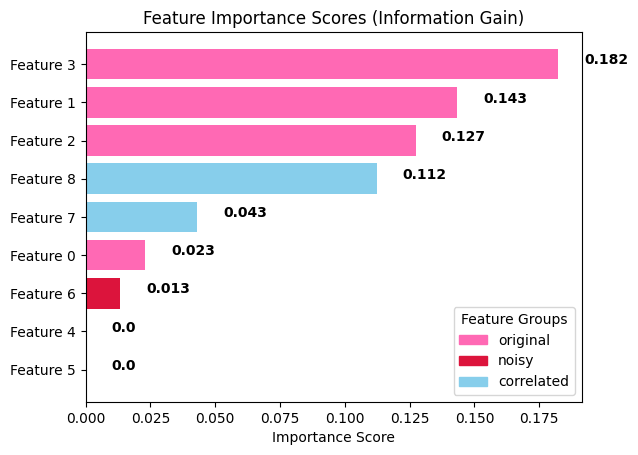

In [37]:
original = 0, n_features - 1
noisy = n_features, n_features - 1 + n_noisy
correlated = n_features + n_noisy,  X.shape[1] -1

colors = []
for feature, value in sorted_features:
    numbers = [int(txt) for txt in feature.split() if txt.isdigit()]
    nr = numbers[0]
    if original[0] <= nr <= original[1]:
        colors.append('hotpink')
    elif noisy[0] <= nr <= noisy[1]:
        colors.append('crimson')
    elif correlated[0] <= nr <= correlated[1]:
        colors.append('skyblue')
    else:
        colors.append('grey')  # Default color for indices outside the defined ranges


# Plot a horizontal bar chart of the feature importance scores
fig, ax = plt.subplots()
y_pos = np.arange(len(sorted_features))
ax.barh(y_pos, [score for feature, score in sorted_features], align="center", color=colors)
ax.set_yticks(y_pos)
ax.set_yticklabels([feature for feature, score in sorted_features])
ax.invert_yaxis()
ax.set_xlabel("Importance Score")
ax.set_title("Feature Importance Scores (Information Gain)")

import matplotlib.patches as mpatches

legend_patches = [
    mpatches.Patch(color='hotpink', label=f'original'),
    mpatches.Patch(color='crimson', label=f'noisy'),
    mpatches.Patch(color='skyblue', label=f'correlated')
]
ax.legend(handles=legend_patches, title="Feature Groups", loc='lower right')

# Add importance scores as labels on the horizontal bar chart
for i, v in enumerate([score for feature, score in sorted_features]):
    ax.text(v + 0.01, i, str(round(v, 3)), color="black", fontweight="bold")
plt.show()


In [38]:
def get_features_ig(X, y):
    sorted_features = calculate_information_gain(X, y)
    chosen_features_ig = []
    for feature, score in sorted_features[:5]:
        res = [int(txt) for txt in feature.split() if txt.isdigit()][0]
        chosen_features_ig.append(res)
    
    return sorted(chosen_features_ig)

chosen_features_ig = get_features_ig(X, y)

In [39]:
chosen_features_ig

[1, 2, 3, 7, 8]

In [40]:
chosen_features['Information Gain'] = chosen_features_ig

#### **2.1.2 – Correlation-based Feature Selection**

In [41]:

import pandas as pd
import seaborn as sns

def CFS(df, threshold=0.75, show=True):
    """Returns features that are correlated.
    (Set of all the names of correlated columns)
    
    Param:
    ------
    df: Pandas DataFrame
    threshold: float. Default, 0.75
        threshold for the correlation
    """
    feature_corr = set()  
    corr_matrix = df.corr()
    if show:
        sns.heatmap(corr_matrix)

    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            # absolute coeff value
            if abs(corr_matrix.iloc[i, j]
                   ) > threshold:  
                # getting the name of column
                colname = corr_matrix.columns[i]  
                feature_corr.add(colname)
    
    if show:    
        print(f'Correlated features to delete: {feature_corr}')
    
    return feature_corr

Correlated features to delete: {8, 7}


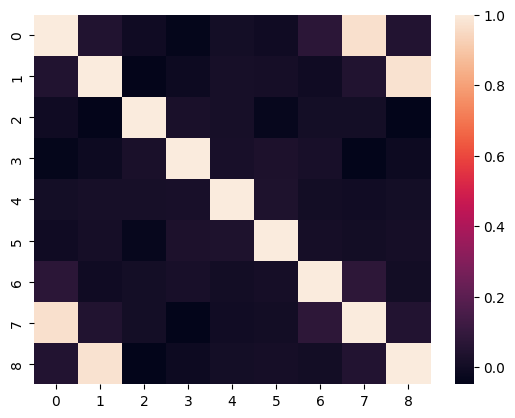

In [42]:
def get_features_cfs(X, threshold=0.75, show=False):
    corr_features = CFS(pd.DataFrame(X), threshold, show)
    chosen_features_cfs = list(set(all_features).difference(set(corr_features)))
    return chosen_features_cfs

chosen_features_cfs = get_features_cfs(X, 0.75, True)

In [43]:
chosen_features_cfs

[0, 1, 2, 3, 4, 5, 6]

In [44]:
chosen_features['Correlation Feature Selection'] = chosen_features_cfs

#### **2.1.3 ANOVA for classification**

In [45]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

def get_features_anova(X, y, all_features, num_features):
    
    KBest_model = SelectKBest(f_classif, k=num_features)
    KBest_model = KBest_model.fit(X, y)
    chosen_features_anova = list(KBest_model.get_feature_names_out(all_features))
    return chosen_features_anova

chosen_features_anova = get_features_anova(X, y, all_features, 5)
chosen_features_anova

[0, 1, 2, 3, 8]

In [46]:
chosen_features['ANOVA'] = chosen_features_anova

### 2.2 Embedded methods

#### **2.2.1 RFE - Recursive Feature Elimination**

In [47]:

from sklearn.feature_selection import RFE
from sklearn.svm import SVC


def get_features_rfe(X, y, n_features_to_select=5):
    estimator = SVC(kernel="linear")
    selector = RFE(estimator, n_features_to_select=n_features_to_select, step=1)
    selector = selector.fit(X, y)
    values_to_choose = selector.ranking_

    return list(np.where(np.array(values_to_choose) == 1)[0])

chosen_features_rfe = get_features_rfe(X, y)
chosen_features_rfe

[0, 1, 2, 3, 8]

In [48]:
chosen_features['RFE'] = chosen_features_rfe

### 2.3 Success index

In [49]:
def calculate_success_index(relevant_selected, all_relevant, irrelevant_selected, all_irrelevant):
    """
    Calculate the success index (Suc).

    Parameters:
    Rs (int): Number of relevant features selected
    Rt (int): Total number of relevant features
    Is (int): Number of irrelevant features selected
    It (int): Total number of irrelevant features

    Returns:
    float: Success index (Suc)
    """
    # Calculate alpha
    alpha = min(0.5, all_relevant/all_irrelevant)

    # Calculate Suc
    success_rate = (relevant_selected / all_relevant - alpha * irrelevant_selected / all_irrelevant) * 100

    return success_rate

In [50]:
all_relevant = set([n for n in range(n_features)])
all_irrelevant = set(all_features).difference(all_relevant)

In [51]:
def calculate_methods_score_print(all_relevant, all_irrelevant, results):
    success_indexes = dict()
    print('\t General:')
    print(f'Relevant features: {all_relevant}')
    print(f'Irrelevant features: {all_irrelevant}\n')
    for method, features in results.items():
        relevant_selected = set(features).intersection(all_relevant)
        irrelevant_selected = set(features).intersection(all_irrelevant)
        print(f'\t{method}')
        print(f'Relevant selected: {relevant_selected}')
        print(f'Irrelevant selected: {irrelevant_selected}\n')
        success_indexes[method] = calculate_success_index(len(relevant_selected), len(all_relevant), len(irrelevant_selected), len(all_irrelevant))
    
    return success_indexes

In [52]:
calculate_methods_score_print(all_relevant, all_irrelevant, chosen_features)

	 General:
Relevant features: {0, 1, 2, 3, 4}
Irrelevant features: {8, 5, 6, 7}

	Information Gain
Relevant selected: {1, 2, 3}
Irrelevant selected: {8, 7}

	Correlation Feature Selection
Relevant selected: {0, 1, 2, 3, 4}
Irrelevant selected: {5, 6}

	ANOVA
Relevant selected: {0, 1, 2, 3}
Irrelevant selected: {8}

	RFE
Relevant selected: {0, 1, 2, 3}
Irrelevant selected: {8}



{'Information Gain': 35.0,
 'Correlation Feature Selection': 75.0,
 'ANOVA': 67.5,
 'RFE': 67.5}

In [53]:
def calculate_methods_score(all_relevant, all_irrelevant, features):
    relevant_selected = set(features).intersection(all_relevant)
    irrelevant_selected = set(features).intersection(all_irrelevant)
    success_index = calculate_success_index(len(relevant_selected), len(all_relevant), len(irrelevant_selected), len(all_irrelevant))

    return success_index

### 2.4 More experiments

In [54]:
from tqdm import tqdm

N_SAMPLES = [1000, 1000, 10_000, 10_000, 25_00, 25_000, 50_000, 50_000]
N_FEATURES = [5, 20] * 4
N_CORRELATED = [2, 10] * 4
N_NOISY = [2, 10] * 4

# Main script
n_classes = 5

final_results = {
    "Information Gain" : [],
    "Correlation Feature Selection": [],
    "ANOVA": [],
    "RFE": []
}

for (n_samples, n_features, n_correlated, n_noisy) in tqdm(zip(N_SAMPLES, N_FEATURES, N_CORRELATED, N_NOISY)):
    X, y = generate_syntetic_data(n_samples, n_features, n_classes, n_correlated, n_noisy)
    
    all_features = [n for n in range(n_features + n_correlated + n_noisy)]
    
    ig_features = get_features_ig(X, y)
    cfs_features = get_features_cfs(X, 0.75, False)
    anova_features = get_features_anova(X, y, all_features, num_features=n_features)
    rfe_features = get_features_rfe(X, y, n_features)
    
    all_relevant = set([n for n in range(n_features)])
    all_irrelevant = set(all_features).difference(all_relevant)
    
    final_results["Information Gain"].append(calculate_methods_score(all_relevant, all_irrelevant, ig_features))
    final_results['Correlation Feature Selection'].append(calculate_methods_score(all_relevant, all_irrelevant, cfs_features))
    final_results['ANOVA'].append(calculate_methods_score(all_relevant, all_irrelevant, anova_features))
    final_results['RFE'].append(calculate_methods_score(all_relevant, all_irrelevant, rfe_features))
    
final_results
                                  
                                  
    

8it [03:33, 26.73s/it]


{'Information Gain': [35.0, 17.5, 67.5, 17.5, 35.0, 10.0, 67.5, 25.0],
 'Correlation Feature Selection': [75.0,
  75.0,
  75.0,
  75.0,
  75.0,
  75.0,
  75.0,
  75.0],
 'ANOVA': [35.0, 40.0, 67.5, 47.5, 35.0, 47.5, 67.5, 47.5],
 'RFE': [67.5, 70.0, 100.0, 100.0, 100.0, 92.5, 100.0, 100.0]}